In [1]:
import kwant

In [2]:
kwant.test()

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-5.3.5, py-1.8.1, pluggy-0.13.1 -- /home/bomin/anaconda3/bin/python
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase('/home/bomin/Desktop/kwant_test/.hypothesis/examples')
rootdir: /home/bomin
plugins: hypothesis-5.5.4, doctestplus-0.5.0, openfiles-0.4.0, arraydiff-0.3, remotedata-0.3.2, astropy-header-0.1.2
collecting ... collected 350 items / 1 skipped / 349 selected

../../anaconda3/lib/python3.7/site-packages/kwant/continuum/tests/test_common.py::test_sympify[k_x * A(x) * k_x-output_expr0] PASSED
../../anaconda3/lib/python3.7/site-packages/kwant/continuum/tests/test_common.py::test_sympify[[[k_x * A(x) * k_x]]-output_expr1] PASSED
../../anaconda3/lib/python3.7/site-packages/kwant/continuum/tests/test_common.py::test_sympify[k_x * sigma_y + k_y * sigma_x-output_expr2] PASSED
../../anaconda3/lib/python3.7/site-packages/kw

<ExitCode.OK: 0>

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

In [148]:
def T(mu):
    """
    This function generates a transfer matrix for a potential V. 
    """
    # Imaginary identity matrix
    Im = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(Im, 1j)
    v = np.ones(N-1)
    # Tight binding Hamiltonian
    H = np.diag(-v, -1) + np.diag(4*np.ones(N)-mu, 0) + np.diag(-v, 1)
    T11 = -Im + 0.5 * H
    T12 = -0.5 * H
    T21 = -0.5 * H
    T22 = Im + 0.5 * H
    return np.array(np.bmat([[T11, T12], [T21, T22]]))

def S(T):
    """
    This function takes a chemical potential as input and 
    generates the Scattering-matrix and the compontents of Scattering.

    The output-format is matrix-like, as it makes the calculations much easier.
    """
    T11 = T[:N, :N]
    T12 = T[:N, N:2*N]
    T21 = T[N:2*N, :N]
    T22 = T[N:2*N, N:2*N]
    T22_inv = np.linalg.inv(T22)

    S11 = -T22_inv.dot(T21)
    S12 = T22_inv
    S21 = T11 - T12.dot(T22_inv).dot(T21)
    S22 = T12.dot(T22_inv)
    return np.array(np.bmat([[S11, S12], [S21, S22]]))

def add_S(S_1, S_2):
    """
    Adds the old S-matrix S_1 to S_2. Implements equation B6 of "Calculation ... Chalker-Coddington
    network model" by Snyman et al.
    """
    S11_1 = S_1[:N, :N]
    S12_1 = S_1[:N, N:2*N]
    S21_1 = S_1[N:2*N, :N]
    S22_1 = S_1[N:2*N, N:2*N]

    S11_2 = S_2[:N, :N]
    S12_2 = S_2[:N, N:2*N]
    S21_2 = S_2[N:2*N, :N]
    S22_2 = S_2[N:2*N, N:2*N]

    inv_1 = np.linalg.inv(np.eye(N) - S11_2.dot(S22_1))
    inv_2 = np.linalg.inv(np.eye(N) - S22_1.dot(S11_2))

    S11 = S11_1 + S12_1.dot(inv_1).dot(S11_2).dot(S21_1)
    S12 = S12_1.dot(inv_1).dot(S12_2)
    S21 = S21_2.dot(inv_2).dot(S21_1)
    S22 = S22_2 + S21_2.dot(inv_2).dot(S22_1).dot(S12_2)

    return np.array(np.bmat([[S11, S12], [S21, S22]]))

def generate_S_tot(V, L):
    """ 
    Generates a S-matrix of the combined slices for a potential V.
    """
    S_tot = S(T(V[:, 0]))
    for j in range(1, L):
        S_tot = add_S(S_tot, S(T(V[:, j])))
    return S_tot

def generate_S_tot_opt(V, L):
    """ 
    Generates a S-matrix by multiplying 10 transfer matrices and then adding it to the S_tot matrix.
    In this way we save processor time. (An overall speedup of the whole program of 2x is reached)
    """
    T_tot = T(V[:, 0])
    S_tot = S(T(V[:, 0]))
    assert L % 10 == 0, "L must be a multiple of 10! Or set the argument 'opt' to false."
    for j in range(1, L):
        if j % 10 != 0:
            T_tot = T(V[:, j]).dot(T_tot)
        else:
            S_tot = add_S(S_tot, S(T_tot))
            T_tot = T(V[:, j])

    return S_tot

def smooth_potential(mu, L, xx=1, yy=1, h=1, plot=False):
    """ 
    Generate a smooth potential
    """
    x = np.linspace(-xx, xx, L)
    y = np.linspace(-yy, yy, N)
    X, Y = np.meshgrid(x, y)
    V = -0.5 * h * (np.tanh(Y**2-X**2) + 1) + mu

    if plot == True:
        fig = plt.figure(figsize=(14,8))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        title = ax.set_title("Potential")
        plt.xlabel('$x$ (L)')
        plt.ylabel('$y$')
        p = ax.plot_surface(X, Y, V)

        ax = fig.add_subplot(1, 2, 2)
        plot = ax.matshow(V)
        fig.colorbar(plot)
        ax.set_xlabel(r'$x$ (L)')
        ax.set_ylabel(r'$y$')
        plt.show()
    return V


def error(S):
    return np.linalg.norm(S.dot(S.T.conj()) - np.eye(len(S)))

## Where the magic happens
##### Calculate the T_tot matrix, the outcomming waves and find the coefficients
The waves are normalized by the current $<I>$. As the current operator is now $\sigma_z$, we divide by the norms.

In [135]:
def solve(mu, V, L, i, opt):
    if opt == True:
        S_tot = generate_S_tot_opt(V, L)
    else:
        S_tot = generate_S_tot(V, L)
    S11 = S_tot[:N, :N]
    S12 = S_tot[:N, N:2*N]
    S21 = S_tot[N:2*N, :N]
    S22 = S_tot[N:2*N, N:2*N]

    # find the eigenvalues and vectorszhihu
    eig_val, eig_vec = np.linalg.eig(T(mu))
    eig_val_round = np.round(eig_val, 10)

    # get indices of the forward and backward propagating waves and the
    # evanescent growing and decaying waves
    idx_R = np.where(eig_val_round.imag > 0.)[0]  # waves that propagate right
    idx_L = np.where(eig_val_round.imag < 0.)[0]  # waves that propagate left
    idx_evan = np.where(eig_val_round.imag == 0)[0]  # evanescent waves
    # evanescent growing waves
    idx_grow = np.where(np.abs(eig_val_round[idx_evan]) > 1)[0]
    # evanescent decaying waves
    idx_dec = np.where(np.abs(eig_val_round[idx_evan]) < 1)[0]

    psi_R = eig_vec[:, idx_R]
    psi_L = eig_vec[:, idx_L]
    ev_dec = eig_vec[:, idx_evan][:, idx_dec]
    ev_grow = eig_vec[:, idx_evan][:, idx_grow]

    # normalize the wavefunctions
    psi_R_norm = np.linalg.norm(
        psi_R[N:2*N], axis=0)**2 - np.linalg.norm(psi_R[:N], axis=0)**2
    psi_L_norm = np.linalg.norm(
        psi_L[:N], axis=0)**2 - np.linalg.norm(psi_L[N:2*N], axis=0)**2
    psi_R /= np.sqrt(np.abs(psi_R_norm))
    psi_L /= np.sqrt(np.abs(psi_L_norm))

    # generate and solve the system of equations for the matching conditions
    U_L_top = np.hstack((-S12.dot(psi_R[N:2*N]), ev_grow[N:2*N] - S11.dot(ev_grow[:N]),
                         psi_L[N:2*N] - S11.dot(psi_L[:N]), -S12.dot(ev_dec[N:2*N])))
    U_L_bot = np.hstack((psi_R[:N] - S22.dot(psi_R[N:2*N]), -S21.dot(ev_grow[:N]),
                         -S21.dot(psi_L[:N]), ev_dec[:N] - S22.dot(ev_dec[N:2*N])))

    U_L = np.vstack((U_L_top, U_L_bot))

    U_R_top = S11.dot(psi_R[:N]) - psi_R[N:2*N]
    U_R_bot = S21.dot(psi_R[:N])
    U_R = np.vstack((U_R_top, U_R_bot))

    # find the coefficients and put them in seperate matrices
    coeff = np.dot(np.linalg.inv(U_L), U_R)

    N_in = psi_L.shape[1]  # number of incomming waves
    N_ev = ev_dec.shape[1]  # number of evanescent waves

    t_matrix = coeff[:N_in, :]
    alpha = coeff[N_in:N_in+N_ev, :]
    r = coeff[N_in+N_ev:2*N_in+N_ev, :]
    beta = coeff[2*N_in+N_ev:2*N_in+2*N_ev, :]

    G = np.linalg.norm(t_matrix)**2

    test = np.sum(np.abs(t_matrix)**2+np.abs(r)**2, axis=0)
    test2 = np.round(np.sum(test)/len(test), 5)
    if test2 != 1:
        print("Unitarity not preserved at " +
              str(i) + " for mu, L " + str(mu) + str(L))

    return G, t_matrix, alpha, r, beta

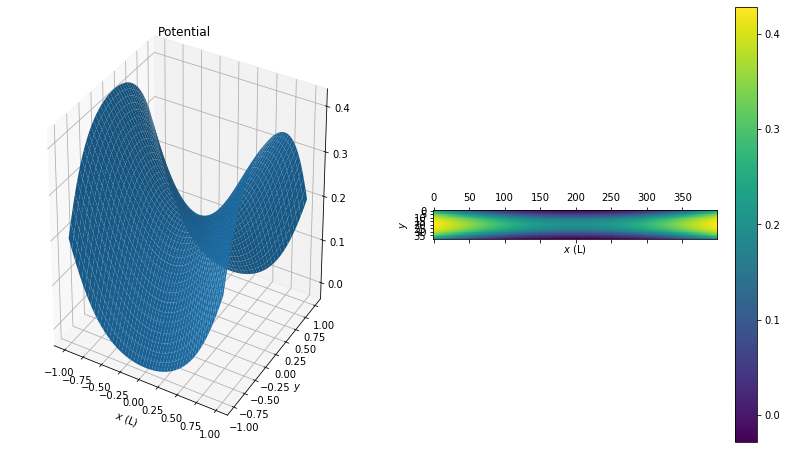

In [149]:
mu = 0.5
L = 400
N = 40
V = smooth_potential(mu, L, xx=1, yy=1, h=.6, plot=True)

# Quantized Conductance of a quantum point contact (QPC)

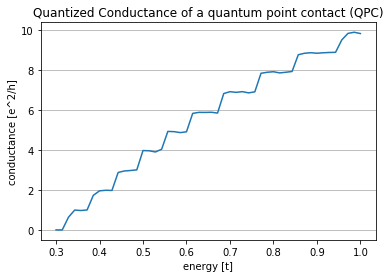

In [177]:
N = 40 # number of transverse lattice points
L = 200 # length of the scattering region

G = []

energies = np.linspace(.3, 1, 50)
for en in energies:
    V = smooth_potential(en, L, xx=1, yy=1, h=.6, plot=False)
    G.append(solve(en, V, L, en, opt = True)[0])
    
plt.plot(energies, G)
plt.title('Quantized Conductance of a quantum point contact (QPC)')
plt.xlabel('energy [t]')
plt.ylabel('conductance [e^2/h]')
plt.grid(b=None, axis='y')
plt.show()

## Leads become available

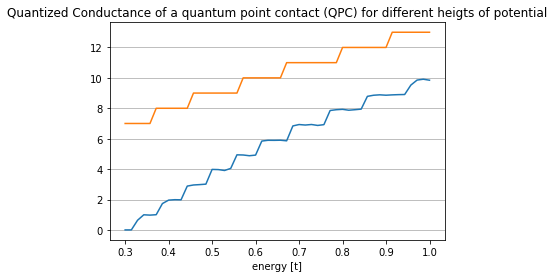

In [178]:
G2 = []
for en in energies:
    V = smooth_potential(en, L, xx=1, yy=1, h=0, plot=False)
    G2.append(solve(en, V, L, en, opt = True)[0])

plt.title('Quantized Conductance of a quantum point contact (QPC) for different heigts of potential')
plt.xlabel('energy [t]')
plt.plot(energies, G, energies, G2)
plt.grid(b=None, axis='y')
plt.show()

# Anderson Localization

/home/bomin/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


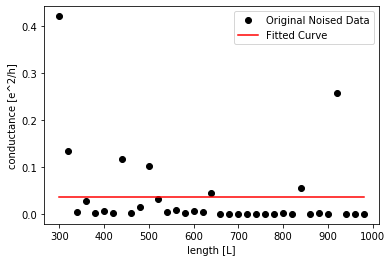

In [179]:
from scipy.optimize import curve_fit
N = 20
G = []
lengths = np.arange(300, 1000, 20)
mu = 0.1
for L in lengths:
    V = np.random.rand(N,L)
    G.append(solve(mu, V, L, L, opt = False)[0])

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, lengths, G)

plt.figure()

plt.plot(lengths, G, 'ko', label="Original Noised Data")
plt.plot(lengths, func(lengths, *popt), 'r-', label="Fitted Curve")
plt.xlabel("length [L]")
plt.ylabel("conductance [e^2/h]")
plt.legend()
plt.show()